In [1]:
import os, sys, re
import pprint as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib widget
%matplotlib inline

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)
sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter') #jupyter-silent to suppress output

In [2]:
total_energy_df = MySpark\
    .spark\
    .read\
    .option("inferSchema", "true")\
    .csv(
        path = "/Processed/TotalEnergyDF",
        header = True)\
    .toPandas()

In [3]:
#individual consumption "^(?=Total)(?!Total Primary).*(?=Consumption$)"
#total consumption "^(?!Total).*(?=Consumption$)"
metrics_s = {
    (i, j) for i,j in zip(total_energy_df["name"], total_energy_df["units"]) 
    if 
        (match:=re.search("Total (Primary|Renewable) Energy Consumed by the", i, re.IGNORECASE))
        and (match:=re.search("Trillion", j, re.IGNORECASE)) 
}
p.pprint(metrics_s)

{('Total Primary Energy Consumed by the Commercial Sector', 'Trillion Btu'),
 ('Total Primary Energy Consumed by the Electric Power Sector', 'Trillion Btu'),
 ('Total Primary Energy Consumed by the Industrial Sector', 'Trillion Btu'),
 ('Total Primary Energy Consumed by the Residential Sector', 'Trillion Btu'),
 ('Total Primary Energy Consumed by the Transportation Sector', 'Trillion Btu'),
 ('Total Renewable Energy Consumed by the Commercial Sector', 'Trillion Btu'),
 ('Total Renewable Energy Consumed by the Electric Power Sector',
  'Trillion Btu'),
 ('Total Renewable Energy Consumed by the Industrial Sector', 'Trillion Btu'),
 ('Total Renewable Energy Consumed by the Residential Sector', 'Trillion Btu')}


In [4]:
total_energy_reduced_df = total_energy_df.loc[
    (
        total_energy_df["name"].isin(
            [i for i, j in metrics_s])
    )].copy()

In [5]:
total_energy_reduced_df["value"] = total_energy_reduced_df[["value",]].apply(pd.to_numeric, errors='coerce', axis=1)
total_energy_reduced_df = total_energy_reduced_df\
    .replace({
        "NA":np.nan
    }).astype(
    {
        "value":"float64",
        "date":"datetime64[ns]"
    }
)
total_energy_reduced_df = total_energy_reduced_df.loc[(~(pd.isna(total_energy_reduced_df["value"])))].copy()
total_energy_reduced_df.dtypes

category_id                   object
childseries                   object
data                          object
end                            int32
f                             object
last_updated          datetime64[ns]
name                          object
notes                         object
parent_category_id            object
series_id                     object
start                          int32
units                         object
date                  datetime64[ns]
value                        float64
dtype: object

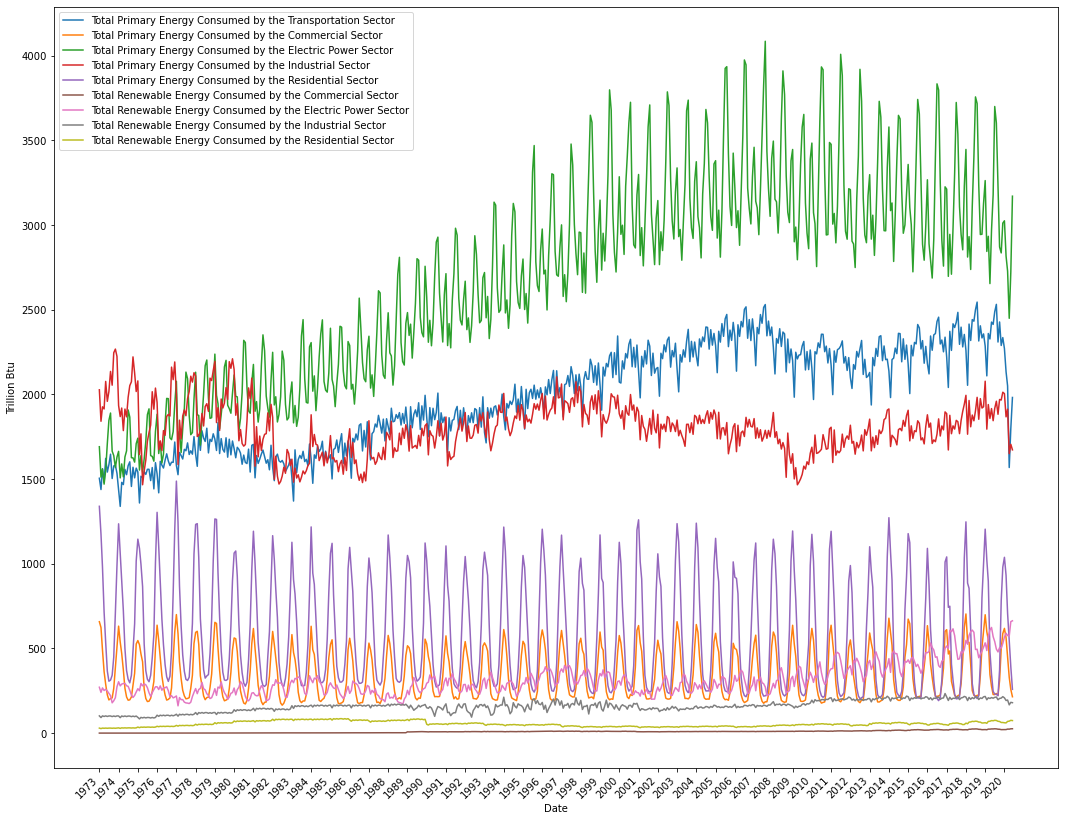

In [6]:
fig, ax = plt.subplots(figsize=(18,14))
fig = sns.lineplot(
    data = total_energy_reduced_df,
    x = total_energy_reduced_df["date"],
    y = "value",
    hue = [re.match(r'^[^,]+', i).group(0) for i in total_energy_reduced_df["name"]],
    ci = None,
    ax = ax
)
ax.set(xlabel = "Date", ylabel = ", ".join(list({j for i, j in metrics_s})))
ax.set_xticks(total_energy_reduced_df["date"].dt.strftime("%Y").sort_values().unique().tolist())
ax.set_xticklabels(
    labels=total_energy_reduced_df["date"].dt.strftime("%Y").sort_values().unique().tolist(),
    rotation=45, ha='right');